In [4]:
from ScanImageTiffReader import ScanImageTiffReader
import json
import ast
from PIL import Image
import os
import tifffile
import numpy as np
import h5py
import matplotlib.pyplot as plt
from murphlib.tools import *

In [2]:
def crop_or_pad(image, target_width, target_height):
    """
    Pad or crop the image to make it 512x512.
    """
    # Crop if larger
    if image.shape[0] > target_height or image.shape[1] > target_width:
        # Center crop to 512x512
        startx = image.shape[1]//2 - (target_width//2)
        starty = image.shape[0]//2 - (target_height//2)    
        image = image[starty:starty+target_height, startx:startx+target_width]
    # Pad if smaller
    if image.shape[0] < target_height or image.shape[1] < target_width:
        # Calculate padding sizes
        pad_x = (target_width - image.shape[1]) // 2
        pad_y = (target_height - image.shape[0]) // 2
        image = np.pad(image, [(pad_y, target_height - image.shape[0] - pad_y), (pad_x, target_width - image.shape[1] - pad_x)], mode='constant')
    return image
def concatenate_tiffs_for_deep_interp(folder_path, num_roi):
    # target output, 512x512
    tiff_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
    tiff_files.sort()  # Ensure files are in the desired order

    if num_roi == 1:
        all_images = []

        for tiff_file in tiff_files:
            with tifffile.TiffFile(os.path.join(folder_path, tiff_file)) as tif:
                for page in tif.pages:
                    image = page.asarray()
                    # Adjust each image to be 512x512
                    processed_image = crop_or_pad(image, 512, 512)
                    all_images.append(processed_image)

        # Save the adjusted images as a new TIFF file
        output_file_path = os.path.join(folder_path, 'concatenated_adjusted_output.tif')
        with tifffile.TiffWriter(output_file_path, bigtiff=True) as tif:
            for image in all_images:
                tif.write(image)

    elif num_roi == 2:
        all_top_images = []
        all_bottom_images = []
        for tiff_file in tiff_files:
            with tifffile.TiffFile(os.path.join(folder_path, tiff_file)) as tif:
                for page in tif.pages:
                    image = page.asarray()
                    # Adjust each image to be 512x512
                    processed_image = crop_or_pad(image, 512, 1024)
                    all_top_images.append(processed_image[:512, :])
                    all_bottom_images.append(processed_image[512:, :])

        # Save the adjusted images as a new TIFF file
        output_file_path1 = os.path.join(folder_path, 'concatenated_top_images.tif')
        output_file_path2 = os.path.join(folder_path, 'concatenated_bottom_images.tif')
        with tifffile.TiffWriter(output_file_path1, bigtiff=True) as tif:
            for image in all_top_images:
                tif.write(image)
        with tifffile.TiffWriter(output_file_path2, bigtiff=True) as tif:
            for image in all_bottom_images:
                tif.write(image)
    

In [3]:
mc_img_folders = [
                  #r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Q_R2\20240415\acq1\suite2p\plane0\reg_tif',
                  #r'Z:\TM_Lab\Edward\Cerebellum_Imaging\O_L2\20240415\suite2p\plane0\reg_tif',
                  r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\soma\suite2p\plane0\reg_tif',
                  r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\dendrite\suite2p\plane0\reg_tif',
                  ] # folder containing fragments of motion corrected tif from suite2p
#test_img_folder = r'Z:\TM_Lab\Edward\Cerebellum_Imaging\O_L3\20240326\acq2\test_tif' # folder containing fragments of motion corrected tif from suite2p
# concatenate_tiffs_for_deep_interp(test_img_folder, num_roi=2)
for folder in mc_img_folders:
    concatenate_tiffs_for_deep_interp(folder, num_roi=2)

: 

In [3]:
def convert_h5_to_tif(h5_file_path, tif_file_path, dataset_name):
    """
    Convert a dataset from an HDF5 file to a TIFF file.

    Parameters:
    - h5_file_path: Path to the input HDF5 file.
    - tif_file_path: Path to the output TIFF file.
    - dataset_name: Name of the dataset within the HDF5 file to convert.
    """
    with h5py.File(h5_file_path, 'r') as h5_file:
        # Access the specified dataset in the HDF5 file
        dataset = h5_file[dataset_name][()]
        
        # Save the dataset as a TIFF file
        tifffile.imwrite(tif_file_path, dataset, photometric='minisblack')

In [4]:
h5_file_paths = [
                        r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\dendrite\concatenated_top_images_interped.h5',
                        r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\dendrite\concatenated_bottom_images_interped.h5',
                        ]
tif_file_paths = [x.replace('.h5', '.tif') for x in h5_file_paths]
for i in range(len(h5_file_paths)):
    convert_h5_to_tif(h5_file_paths[i], tif_file_paths[i], "data")

In [9]:
def convert_h5_to_stitched_tif(left_h5_file_path, right_h5_file_path, tif_file_path, left_dataset_name = "data", right_dataset_name = "data"):
    """
    Convert datasets from two HDF5 files (left and right image stacks) to a single stitched TIFF file.

    Parameters:
    - left_h5_file_path: Path to the input HDF5 file containing left image stacks.
    - right_h5_file_path: Path to the input HDF5 file containing right image stacks.
    - tif_file_path: Path to the output stitched TIFF file.
    - left_dataset_name: Name of the dataset within the left HDF5 file.
    - right_dataset_name: Name of the dataset within the right HDF5 file.
    """
    with h5py.File(left_h5_file_path, 'r') as left_h5_file, h5py.File(right_h5_file_path, 'r') as right_h5_file:
        # Access the specified datasets in the HDF5 files
        left_dataset = left_h5_file[left_dataset_name][()]
        right_dataset = right_h5_file[right_dataset_name][()]
        
        # Check that the number of frames in both datasets are the same
        assert left_dataset.shape[0] == right_dataset.shape[0], "Left and right datasets must have the same number of frames"
        
        # List to hold stitched frames
        stitched_frames = []
        
        # Iterate over each frame and stitch the left and right images
        for left_frame, right_frame in zip(left_dataset, right_dataset):
            # Stitch the images side-by-side
            stitched_frame = np.hstack((left_frame, right_frame))
            stitched_frames.append(stitched_frame)
        
        # Save the stitched frames as a TIFF file
        tifffile.imwrite(tif_file_path, stitched_frames, photometric='minisblack', bigtiff=True)

h5_file_paths = [
                        r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\soma\concatenated_top_images_interped.h5',
                        r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\soma\concatenated_bottom_images_interped.h5',
                        ]
tif_file_path = os.path.join(os.path.dirname(h5_file_paths[0]), "deep_interped_combined_images.tif")
convert_h5_to_stitched_tif(left_h5_file_path = h5_file_paths[0], right_h5_file_path = h5_file_paths[1], tif_file_path=tif_file_path)


In [7]:
def concatenate_tiffs_left_right_roi(file1, file2, output_file):
    with tifffile.TiffFile(file1) as tif1, tifffile.TiffFile(file2) as tif2:
        # Check if the number of frames and the heights are the same
        if len(tif1.pages) != len(tif2.pages):
            print("The TIFF files do not have the same number of frames and cannot be concatenated.")
            return

        concatenated_frames = []
        for page1, page2 in zip(tif1.pages, tif2.pages):
            img1 = page1.asarray()
            img2 = page2.asarray()
            
            if img1.shape[0] != img2.shape[0]:
                print("The TIFF frames do not have the same height and cannot be concatenated.")
                return
            
            concatenated_img = np.concatenate((img1, img2), axis=1)
            concatenated_frames.append(concatenated_img)

        # Save the concatenated image
        with tifffile.TiffWriter(output_file, bigtiff=True) as tif_writer:
            for frame in concatenated_frames:
                tif_writer.write(frame, photometric='minisblack')
        
        print(f"Concatenated TIFF saved as {output_file}.")

In [8]:
left_roi_tif = r"Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\soma\concatenated_top_images.tif"
right_roi_tif = r"Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\soma\concatenated_bottom_images.tif"
outfile = os.path.join(os.path.dirname(left_roi_tif), "raw_combined_images.tif")
concatenate_tiffs_left_right_roi(left_roi_tif, right_roi_tif, outfile)

Concatenated TIFF saved as Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\dendrite\raw_combined_images.tif.


In [2]:
img_path = r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\20240821\arm1\arm1_150sq_1024pix_15hz_etl115_00002.tif'
reader=ScanImageTiffReader(img_path)

: 

: 

In [14]:
tifffilepath = r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R3\linear_reference_20241126_00002.tif'
stack = []
mean_fluo = []
with tifffile.TiffFile(tifffilepath) as tif:
        for ind, page in enumerate(tif.pages):
            #if ind>26000 and ind<28000:
            image = page.asarray()
            stack.append(image)
            mean_fluo.append(np.mean(image))
            

In [15]:
mean_img = np.mean(np.stack(stack), axis=0)
np.save(r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R3\linear_ref.npy',mean_img)

In [3]:
paths = [
    # r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\20240815',
    # r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\20240821',
     r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R3\20240904',
     r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R3\20240910',
     r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R3\20240918',
     r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R3\20240924',
     #r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\20241015',
     r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R3\20241018',
     r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R3\20241111',
    #  r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_L2\20241115',
     r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R3\20241119',
]
for path in paths:
    subdir = [d for d in os.listdir(path)]
    if 'arm1' in subdir:
        arm1dir = os.path.join(path,'arm1')
        arm1_tiff = find_tif_file(arm1dir)
        arm1_stack = []
        with tifffile.TiffFile(arm1_tiff) as tif:
                for ind, page in enumerate(tif.pages):
                    if ind>100 and ind<300:
                        image = page.asarray()
                        arm1_stack.append(image)
        mean_arm1_img = np.mean(np.stack(arm1_stack), axis=0)
        print(mean_arm1_img.shape)
        np.save(os.path.join(arm1dir, 'mean_img.npy'), mean_arm1_img)
    if 'arm2' in subdir:
        arm2dir = os.path.join(path,'arm2')
        arm2_tiff = find_tif_file(arm2dir)
        arm2_stack = []
        with tifffile.TiffFile(arm2_tiff) as tif:
                for ind, page in enumerate(tif.pages):
                    if ind>100 and ind<300:
                        image = page.asarray()
                        arm2_stack.append(image)
        mean_arm2_img = np.mean(np.stack(arm2_stack), axis=0)
        np.save(os.path.join(arm2dir, 'mean_img.npy'), mean_arm2_img)

(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)


In [ ]:

pulsestack = stack[1:1000:2]
pulse_array = np.array([])
for i in range(len(pulsestack)):
    pulse_array = np.concatenate((pulse_array,pulsestack[i].flatten()))


KeyboardInterrupt: 

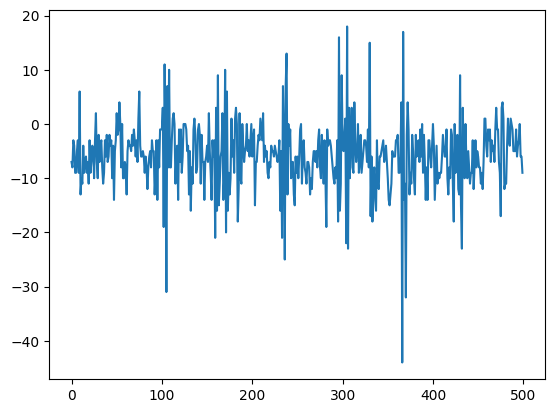

In [39]:
plt.plot(pulsestack[0].flatten()[:500])

In [23]:
stack1 = stack.copy()
for i in range(40):
    stack1[i] = stack[40]

In [15]:
mean_fluo1 = [np.mean(image) for image in stack1[:100]]

In [18]:
substack = stack1[:43200]
# Save the adjusted images as a new TIFF file
output_file_path = r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2\20240821\arm1\arm1_150sq_1024pix_15hz_etl115_00002_modified.tif'
with tifffile.TiffWriter(output_file_path, bigtiff=True) as tif:
    for ind,image in enumerate(substack):
        tif.write(image)
        if ind%1000==0:
                print(f'{ind}/{len(substack)} frames done')

0/43200 frames done
1000/43200 frames done
2000/43200 frames done
3000/43200 frames done
4000/43200 frames done
5000/43200 frames done
6000/43200 frames done
7000/43200 frames done
8000/43200 frames done
9000/43200 frames done
10000/43200 frames done
11000/43200 frames done
12000/43200 frames done
13000/43200 frames done
14000/43200 frames done
15000/43200 frames done
16000/43200 frames done
17000/43200 frames done
18000/43200 frames done
19000/43200 frames done
20000/43200 frames done
21000/43200 frames done
22000/43200 frames done
23000/43200 frames done
24000/43200 frames done
25000/43200 frames done
26000/43200 frames done
27000/43200 frames done
28000/43200 frames done
29000/43200 frames done
30000/43200 frames done
31000/43200 frames done
32000/43200 frames done
33000/43200 frames done
34000/43200 frames done
35000/43200 frames done
36000/43200 frames done
37000/43200 frames done
38000/43200 frames done
39000/43200 frames done
40000/43200 frames done
41000/43200 frames done
42000

In [24]:
vol=reader.data()
print('Frame: %s Height: %s Width: %s' %(vol.shape[0], vol.shape[1], vol.shape[2]))

Frame: 14317 Height: 1040 Width: 512


In [ ]:
frames_metadata = []

with ScanImageTiffReader(img_path) as reader:
    num_frames = reader.shape()[0]  # Assuming the first dimension represents frames
    
    for i in range(num_frames):
        description = reader.description(i)
        frame_metadata = {}  # Dictionary to hold this frame's metadata
        
        for line in description.split('\n'):
            if '=' in line:  # Ensure there's a key-value pair to parse
                key, value = line.split('=', 1)  # Split by the first '='
                key = key.strip()
                
                try:
                    # Safely evaluate the value string to the appropriate Python data type
                    # This works for numbers, lists, dictionaries, etc.
                    value = ast.literal_eval(value.strip())
                except (ValueError, SyntaxError):
                    # If evaluation fails, keep the value as a string
                    value = value.strip()
                
                frame_metadata[key] = value
        
        frames_metadata.append(frame_metadata)


In [37]:
frames_metadata[0]

{'frameNumbers': 1,
 'acquisitionNumbers': 1,
 'frameNumberAcquisition': 1,
 'frameTimestamps_sec': 0.0,
 'acqTriggerTimestamps_sec': -0.00011737,
 'nextFileMarkerTimestamps_sec': -1.0,
 'endOfAcquisition': 0,
 'endOfAcquisitionMode': 0,
 'dcOverVoltage': 0,
 'epoch': '[2024  3  5 12 25 15.238]',
 'auxTrigger0': [],
 'auxTrigger1': [],
 'auxTrigger2': [],
 'auxTrigger3': [],
 'I2CData': {}}

In [38]:
all_auxTrigger0 = []

# Iterate through each frame's metadata
for frame_metadata in frames_metadata:
    # Check if 'auxTrigger0' exists and is not empty
    if 'auxTrigger0' in frame_metadata and frame_metadata['auxTrigger0']:
        # Extend the all_auxTrigger0 list with the numbers from this frame's auxTrigger0
        all_auxTrigger0.extend(frame_metadata['auxTrigger0'])

In [39]:
all_auxTrigger0

[33.78155021,
 45.68120846,
 46.73831696,
 57.58207253,
 58.64988146,
 67.60462751,
 68.66533688,
 76.1923746,
 77.24698399,
 89.06634541,
 90.20465545,
 99.51650445,
 100.57881332,
 106.30794343,
 107.3560526,
 119.87042058,
 120.94502926,
 130.54347846,
 131.60688759,
 144.02305433,
 145.0975635,
 154.54891217,
 155.61202118,
 167.29938358,
 168.37039251,
 176.15663213,
 177.21324122,
 187.68489387,
 188.75160327]

In [34]:
with ScanImageTiffReader(img_path) as reader:
    description = reader.description(1)
    print(type(description))
    print(description)
    print(reader.shape()[0])

<class 'str'>
frameNumbers = 2
acquisitionNumbers = 1
frameNumberAcquisition = 2
frameTimestamps_sec = 0.065715060
acqTriggerTimestamps_sec = -1.000000000
nextFileMarkerTimestamps_sec = -1.000000000
endOfAcquisition = 0
endOfAcquisitionMode = 0
dcOverVoltage = 0
epoch = [2024  3  5 12 25 15.238]
auxTrigger0 = []
auxTrigger1 = []
auxTrigger2 = []
auxTrigger3 = []
I2CData = {}
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [ ]:
with ScanImageTiffReader(img_path) as reader:
    o=json.loads(reader.metadata())
    print(o["RoiGroups"]["imagingRoiGroup"]["rois"]["scanfields"]["affine"])